# Импорт библиотек

In [3]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

# Считываю файл 

In [4]:
task = pd.read_excel('data.xlsx')

In [5]:
task['client_id'] = task['client_id'].fillna(0)
task['client_id'] = task['client_id'].astype('int64')

In [64]:
task_may = task[1: 129].set_index('client_id')
task_june = task[130: 258].set_index('client_id')
task_july = task[259: 369].set_index('client_id')
task_augus = task[370: 484].set_index('client_id')
task_september = task[485: 594].set_index('client_id')
task_october = task[595:].set_index('client_id')

# 1) Вычислите общую выручку за июль 2021 по тем сделкам, приход денежных средств которых не просрочен.

In [7]:
task_july_copy = task_july[task_july['status'] != 'ПРОСРОЧЕНО'] 

In [8]:
pd.pivot_table(task_july_copy, index='status', values='sum', aggfunc='sum')

,sum
status,
ОПЛАЧЕНО,859896.47


# 2) Как изменялась выручка компании за рассматриваемый период? Проиллюстрируйте графиком.

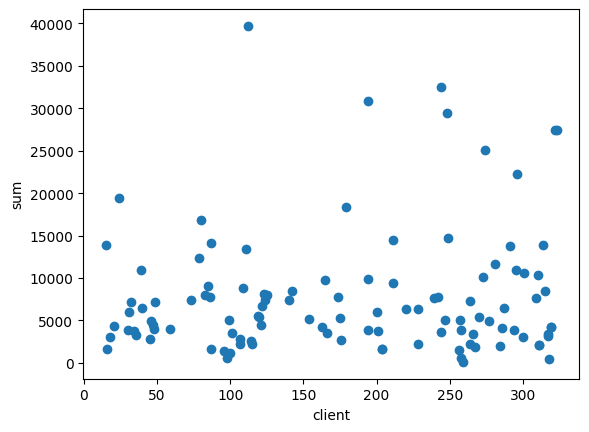

In [72]:
plt.xlabel('client')
plt.ylabel('sum')
plt.scatter(x=task_july.index, y=task_july['sum'])

# 3) Кто из менеджеров привлек для компании больше всего денежных средств в сентябре 2021?

In [10]:
task_september_1 = pd.pivot_table(task_september, index='sale', values='sum', aggfunc='sum')

In [11]:
task_september_1[task_september_1['sum'] == task_september_1['sum'].max()]

,sum
sale,
Смирнов,221525.7


# 4) Какой тип сделок (новая/текущая) был преобладающим в октябре 2021?

In [12]:
task_october['new/current'].value_counts() # Преобладает 'текущая'

new/current
текущая    99
новая      36
Name: count, dtype: int64

# 5) Сколько оригиналов договора по майским сделкам было получено в июне 2021?

In [56]:
a = 0
for i in task_july['document']:
    if i == 'оригинал':
        a += 1
print(f'Оригиналов договора по майским сделкам было получено в июне 2021 года - {a} шт')

Оригиналов договора по майским сделкам было получено в июне 2021 года - 106 шт


# Объеденяю все таблицы 

In [14]:
all_table = pd.concat([task_may, 
                       task_june, 
                       task_july, 
                       task_augus, 
                       task_september, 
                       task_october],
                     keys = ['Май 2021',
                             'Июнь 2021',
                             'Июль 2021',
                             'Август 2021',
                             'Сентябрь 2021',
                             'Октябрь 2021'])

In [15]:
all_table = all_table.drop(columns = ['Unnamed: 5'], axis = 1) # убираю пустой столбец

#   Задание: За каждую заключенную сделку менеджер получает бонус, который рассчитывается следующим образом.

    1) За новые сделки менеджер получает 7 % от суммы, при условии, что статус оплаты «ОПЛАЧЕНО», а также имеется оригинал подписанного договора с клиентом (в рассматриваемом месяце).
    2) За текущие сделки менеджер получает 5 % от суммы, если она больше 10 тыс., и 3 % от суммы, если меньше. При этом статус оплаты может быть любым, кроме «ПРОСРОЧЕНО», а также необходимо наличие оригинала подписанного договора с клиентом (в рассматриваемом месяце).

    Бонусы по сделкам, оригиналы для которых приходят позже рассматриваемого месяца, считаются остатком на следующий период, который выплачивается по мере прихода оригиналов. Вычислите остаток каждого из менеджеров на 01.07.2021.

In [16]:
bonus = all_table[1:] # Убрал первую строку, на давала перевести в формат datatime

In [17]:
bonus.replace({pd.NaT: None}, inplace=True) # перевожу NaT в None
bonus['receiving_date'] = bonus['receiving_date'].fillna(0).astype('datetime64[ns]') # перевожу в формат  datatime

C:\Users\Dexp\AppData\Local\Temp\ipykernel_9536\3096928664.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bonus.replace({pd.NaT: None}, inplace=True) # перевожу NaT в None
C:\Users\Dexp\AppData\Local\Temp\ipykernel_9536\3096928664.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bonus['receiving_date'] = bonus['receiving_date'].fillna(0).astype('datetime64[ns]') # перевожу в формат  datatime


In [18]:
bonus = bonus[bonus['receiving_date'] < '2021-07-01'] # На месте пустых значений появился 1970 год
bonus = bonus[bonus['receiving_date'] > '1970-01-01'] # Как понял нужно работать с имеющимяся датами, исключил пустые значения(знач где 1970)

In [19]:
bonus_1 = bonus[bonus['status'] == 'ОПЛАЧЕНО'] # создаю тоблицу где все оплачено 
bonus_1 = bonus[bonus['document'] == 'оригинал'] # строки где имеется оригиналы 
bonus_1 = bonus[bonus['new/current'] == 'новая'] # только новые сделки

In [20]:
bonus_result_1 = pd.pivot_table(bonus_1, index='sale', values='sum', aggfunc='sum')  # считаем сумму прибыли по 1 пункту из задания 

In [21]:
bonus_result_1["Рассчет за новые сделки"] = (bonus_result_1['sum'] * 0.07) # Рассчет за новые сделки

In [22]:
# Далее высчитываю значения из пункта 2 для рассчета бонуса '>' и '<' 10 000р 
bonus_2 = bonus[bonus['new/current'] == 'текущая'] # Таблица с текущими сделками 
bonus_2 = bonus_2[bonus_2['status'] != 'ПРОСРОЧЕНО'] # без просрочек 
bonus_2 = bonus_2[bonus_2['document'] == 'оригинал'] # с оригинальными документаими

In [23]:
bonus_deal_1 = bonus_2[bonus_2['sum'] > 10000] # Сделки более 10 000 
bonus_deal_2 = bonus_2[bonus_2['sum'] <= 10000] # Сделки менее 10 000

In [24]:
bonus_result_2 = pd.pivot_table(bonus_deal_1, index='sale', values='sum', aggfunc='sum') # Cводная таблица где сделки более 10 000
bonus_result_3 = pd.pivot_table(bonus_deal_2, index='sale', values='sum', aggfunc='sum') # Cводная таблица где сделки менее 10 000

In [26]:
bonus_result_1["Рассчет за cделки < 10 000"] = (bonus_result_2['sum'] * 0.03) # Высчитываем по формуле менее 10 000
bonus_result_1["Рассчет за cделки > 10 000"] = (bonus_result_3['sum'] * 0.05) # Высчитываем по формуле более 10 000

In [27]:
bonus_result_1 = bonus_result_1.fillna(0) # заполняю пустые значения 

In [28]:
# Считаем итоговый результат 
bonus_result_1['Итого'] = (
                           bonus_result_1["Рассчет за новые сделки"] +
                           bonus_result_1["Рассчет за cделки < 10 000"] + 
                           bonus_result_1["Рассчет за cделки > 10 000"]
                            )  

In [29]:
bonus_result_1 = bonus_result_1.drop(columns = ['sum'], axis = 1)
bonus_result_1 # Получаем остаток каждого из менеджеров на 01.07.2021

,Рассчет за новые сделки,Рассчет за cделки < 10 000,Рассчет за cделки > 10 000,Итого
sale,,,,
Андреев,1144.3390,1682.568,1415.9745,4242.8815
Васильев,35.2590,0.000,506.6200,541.8790
Кузнецова,424.1321,0.000,3634.2325,4058.3646
Петрова,770.2590,2246.400,4190.9050,7207.5640
Смирнов,696.4090,2033.688,1148.7400,3878.8370
